In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm.notebook import trange, tqdm

import pickle
import random 

rng = np.random.default_rng(926334)

#labels helpers and processing
def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def daynum_gen(date_time):
    '''converts date time objects to filename'''
    date_time = datetime.fromisoformat(date_time)
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

Load data

In [2]:
data_path = "C:/Users/Matt/Dropbox/SnowComp/FinalData/"

y_train  = pd.read_csv(data_path + "train_y.csv")
y_test  = pd.read_csv(data_path + "test_y.csv")

x_train = np.load(data_path + "train_dataset.npy")
x_test = np.load(data_path + "test_datast.npy")

## Outcome Histogram

In [ ]:
fig, ax = plt.subplots(figsize = (10,7))
ax.hist(x_train.flatten()*255,
        weights = np.ones_like(x_train.flatten()) / x_train.flatten().size*100,
        bins = 15, edgecolor='black', linewidth=1.1)
ax.ticklabel_format(style='plain')
ax.set_ylabel("Percentage of Data", fontsize= 16)
ax.set_xlabel("Pixel Value", fontsize= 16)
ax.set_title("Training Data", fontsize= 16)
plt.show()

## Image pixel value distribution

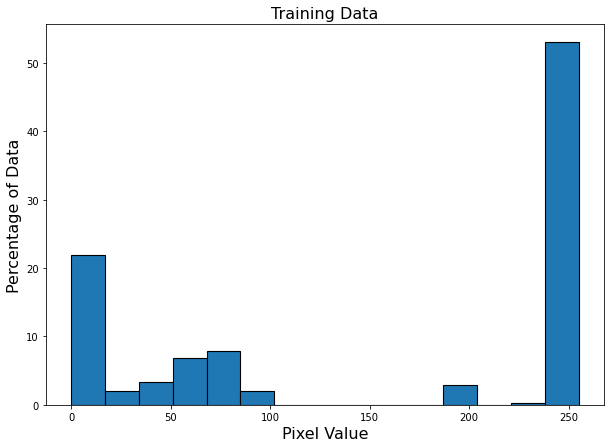

In [4]:
fig, ax = plt.subplots(figsize = (10,7))
ax.hist(x_train.flatten()*255,
        weights = np.ones_like(x_train.flatten()) / x_train.flatten().size*100,
        bins = 15, edgecolor='black', linewidth=1.1)
ax.ticklabel_format(style='plain')
ax.set_ylabel("Percentage of Data", fontsize= 16)
ax.set_xlabel("Pixel Value", fontsize= 16)
ax.set_title("Training Data", fontsize= 16)
plt.show()

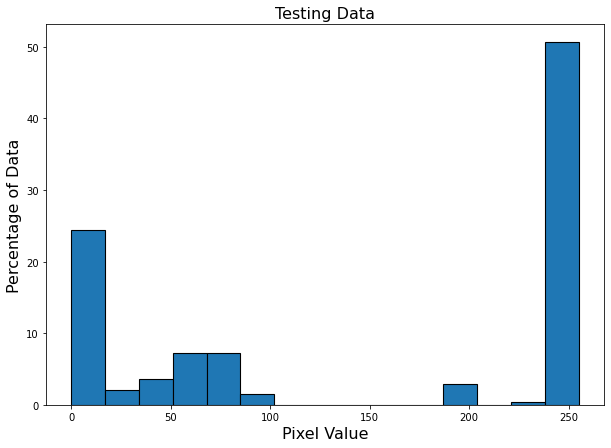

In [5]:
fig, ax = plt.subplots(figsize = (10,7))
ax.hist(x_test.flatten()*255,
        weights = np.ones_like(x_test.flatten()) / x_test.flatten().size*100,
        bins = 15, edgecolor='black', linewidth=1.1)
ax.ticklabel_format(style='plain')
ax.set_ylabel("Percentage of Data", fontsize= 16)
ax.set_xlabel("Pixel Value", fontsize= 16)
ax.set_title("Testing Data", fontsize= 16)
plt.show()

In [6]:
#percentage more than 100 (55.67%)

round(((x_test.flatten()*255 > 100).sum() +(x_train.flatten()*255 > 100).sum())/(
    len(x_train.flatten()) + len(x_test.flatten())), 4)

0.5567

## How many have both Aqua and Terra images on one day

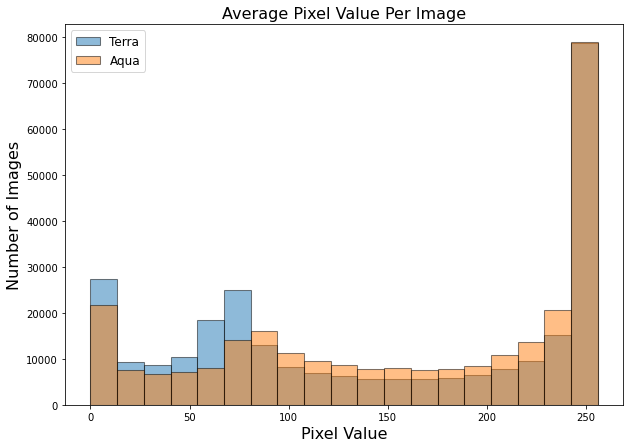

In [7]:
#aqua average pixel value
plt_data = (np.vstack((x_train, x_test))*255).mean(axis = (2,3))

fig, ax = plt.subplots(figsize = (10,7))

bins = np.linspace(0, 256, 20)

ax.hist(plt_data[:,0], bins, alpha=0.5, label='Terra',
        edgecolor='black', linewidth=1.05)
ax.hist(plt_data[:,1], bins, alpha=0.5, label='Aqua',
        edgecolor='black', linewidth=1.05)

ax.ticklabel_format(style='plain')
ax.set_ylabel("Number of Images", fontsize= 16)
ax.set_xlabel("Pixel Value", fontsize= 16)
ax.set_title("Average Pixel Value Per Image", fontsize= 16)

ax.legend(fontsize = 12)
plt.show()

In [8]:
total = plt_data.shape[0]

#how many 0, how many 250+?
print("less than 1:", (plt_data < 1).sum(axis=0)/total*100)
print("greater than 249:", (plt_data > 249).sum(axis=0)/total*100)
print("greater than 100:", (plt_data > 100).sum(axis=0)/total*100)

less than 1: [4.10056432 3.2918328 ]
greater than 249: [22.73677376 21.48409714]
greater than 100: [57.67237071 68.52075452]


## Within-image Missingness histogram

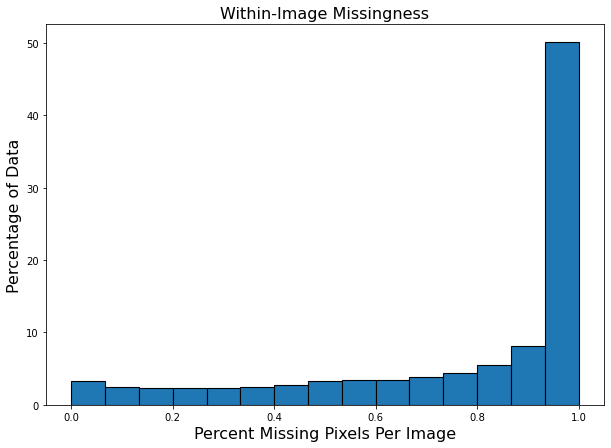

In [9]:
plt_data = ((np.vstack((x_train, x_test))*255 > 100) |
 (np.vstack((x_train, x_test))*255 < 1)).sum(axis = (1,2,3))/(21*21*2)


fig, ax = plt.subplots(figsize = (10,7))
ax.hist(plt_data.flatten(),
        weights = np.ones_like(plt_data) / plt_data.size*100,
        bins = 15, edgecolor='black', linewidth=1.1)
ax.ticklabel_format(style='plain')
ax.set_ylabel("Percentage of Data", fontsize= 16)
ax.set_xlabel("Percent Missing Pixels Per Image", fontsize= 16)
ax.set_title("Within-Image Missingness", fontsize= 16)
plt.show()

In [10]:
print("100% missing:", (plt_data > .999).sum()/len(plt_data)*100)

100% missing: 21.905425468659374


## Panel of images + predictions, compared to actual values

In [11]:
ROOT = 'C:/Users/Matt/Documents/Python Scripts/SnowComp/realtime/'
MODIS_CNN_PATH = ROOT + 'model_32_18_8_3_0.13_50_1399_0.0001' #'modis_model'

import importlib
import sys
sys.path.append(ROOT)
importlib.reload(cnn)

import torch
from modis_cnn import Net as ModisNet

net_kwargs = {'cdim1': 32,
              'cdim2': 18,
              'cdim3': 8,
              'kernel_sz': 3,
              'dropout': 0.13,
              'ldim': 50}


modis_net = ModisNet(**net_kwargs)
modis_net.load_state_dict(torch.load(MODIS_CNN_PATH))

c1 dim: 19
mp0 dim: 17
c2 dim: 15
mp1 dim: 13
c3 dim: 11
mp2 dim: 9
flattened_dim 648


<All keys matched successfully>

In [14]:
nsamples = 8
idx = np.random.randint(low=0, high=x_test.shape[0], size=(nsamples,)) 
y_test.iloc[idx,0].values

array(['SNOTEL:777_WA_SNTL', 'SNOTEL:430_CO_SNTL', 'SNOTEL:849_NV_SNTL',
       'SNOTEL:489_ID_SNTL', 'SNOTEL:1034_NM_SNTL', 'SNOTEL:1147_NV_SNTL',
       '95f6dfce-1272-42c9-84a4-99c50465e2fb', 'SNOTEL:767_OR_SNTL'],
      dtype=object)

In [15]:
y_train[y_train.cell_id == y_test.iloc[idx,0].values[0]]

,cell_id,snowpack,date
3788,SNOTEL:777_WA_SNTL,0.0,2014147
3832,SNOTEL:777_WA_SNTL,0.0,2018163
4010,SNOTEL:777_WA_SNTL,4.7,2014056
5703,SNOTEL:777_WA_SNTL,1.9,2017339
6700,SNOTEL:777_WA_SNTL,2.2,2013344
...,...,...,...
218369,SNOTEL:777_WA_SNTL,11.1,2016026
219329,SNOTEL:777_WA_SNTL,17.6,2013043
219534,SNOTEL:777_WA_SNTL,10.0,2017066
220927,SNOTEL:777_WA_SNTL,0.0,2013155


### Training

Match the training and testing datasets by location in different times


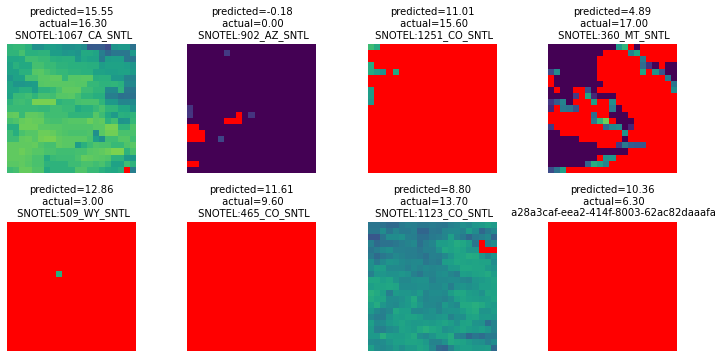

In [16]:
nsamples = 8

idx = np.random.randint(low=0, high=x_test.shape[0], size=(nsamples,))
# idx = np.array([176120,  16587, 120640, 172680, 181050, 109652, 118646, 217709]) # good set of train not completely missing days
# idx = np.array([  813,  2586,  8527, 47244, 45731, 21826, 10435, 44521]) #decent test set

modis_net.eval()

samples = x_test[idx]
preds = modis_net(torch.Tensor(x_test[idx])).detach().numpy()
actual = y_test.iloc[idx].snowpack.values
sites = y_test.iloc[idx,0].values

modis_net.train()

nrows = 2
ncols = 4
h = 3 * nrows
w = 3 * ncols

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(w, h))

for i in range(nsamples):
    ii = i // ncols
    jj = i % ncols
    

    which_sat = 0 if (samples[i, 0, :, :]*255 >100).sum() <= (samples[i, 1, :, :]*255 >100).sum() else 1
    
    samples[i, which_sat, :, :][samples[i, which_sat, :, :] > .395] = np.nan #above 100/255
    
    current_cmap = cm.get_cmap().copy()
    current_cmap.set_bad(color='red')
    
    ax[ii, jj].imshow(
        samples[i, which_sat, :, :], vmin=0, vmax=.395,
        cmap = current_cmap
    )
    
    #title would be prediction score vs actual
    ax[ii, jj].set_title(
        f"predicted={float(preds[i]):.2f}\n actual={float(actual[i]):.2f}\n {sites[i]}", fontsize=10
    )
    
    ax[ii, jj].axis("off")
    
fig.subplots_adjust(hspace=0.2, wspace=0.4)


## More missingness stats 

First, how many observations are ground sites in training and testing?

In [17]:
def is_groundsite(name):
    if name[0:4] in {"CDEC", "SNOT"}:
        return True
    return False

ground_idx_te = y_test.cell_id.map(is_groundsite)
print("testing obs ground:",ground_idx_te.sum(), "of", len(ground_idx_te), f"({ground_idx_te.sum()/len(ground_idx_te):.2%})") 

ground_idx_tr = y_train.cell_id.map(is_groundsite)
print("training obs ground:",ground_idx_tr.sum(), "of", len(ground_idx_tr), f"({ground_idx_tr.sum()/len(ground_idx_tr):.2%})") 

testing obs ground: 38628 of 52400 (73.72%)
training obs ground: 144015 of 221733 (64.95%)


Less missingness for ASO observations, probably because very adverse weather is not good to fly in

In [18]:
missing_pix = (x_train[ground_idx_tr.values] *255 > 100.1).sum()
total_pix = len(x_train[ground_idx_tr.values].flatten())
print("training pixels missing (Ground): ", missing_pix, "of", total_pix, f"({missing_pix/total_pix:.2%})") 

missing_pix = (x_test[ground_idx_te.values] *255 > 100.1).sum()
total_pix = len(x_test[ground_idx_te.values].flatten())
print("testing pixels missing (Ground): ", missing_pix, "of", total_pix, f"({missing_pix/total_pix:.2%})") 

missing_pix = (x_train[~ground_idx_tr.values] *255 > 100.1).sum()
total_pix = len(x_train[~ground_idx_tr.values].flatten())
print("training pixels missing (ASO): ", missing_pix, "of", total_pix, f"({missing_pix/total_pix:.2%})") 

missing_pix = (x_test[~ground_idx_te.values] *255 > 100.1).sum()
total_pix = len(x_test[~ground_idx_te.values].flatten())
print("testing pixels missing (ASO): ", missing_pix, "of", total_pix, f"({missing_pix/total_pix:.2%})") 

training pixels missing (Ground):  79925244 of 127021230 (62.92%)
testing pixels missing (Ground):  19589920 of 34069896 (57.50%)
training pixels missing (ASO):  29808269 of 68547276 (43.49%)
testing pixels missing (ASO):  5285374 of 12146904 (43.51%)


How many totally missing on both sats?

In [19]:
print(np.all(x_train*255 > 100.1, axis = (1,2,3)).sum(), "completely missing training")
print(np.all(x_test*255 > 100.1, axis = (1,2,3)).sum(), "completely missing testing")

35602 completely missing training
6489 completely missing testing


Where do all missing images get mapped to?
The mean value of the training or testing set for those images?

**Note these are with dropout engaged**

In [20]:
missing_train = x_train[np.all(x_train*255 > 100.1, axis = (1,2,3))]

np.set_printoptions(suppress=True)
print(np.dstack(np.unique(missing_train*255,return_counts=True)))

[[[     200.      145.]
  [     201.   861866.]
  [     237.       32.]
  [     239.      233.]
  [     250. 30224457.]
  [     254.      454.]
  [     255.   313777.]]]


(array([    2.,     2.,     1.,    11.,    16.,   124., 33510.,  1928.,
            7.,     1.]),
 array([-398.2632  , -339.14404 , -280.02487 , -220.90572 , -161.78654 ,
        -102.66738 ,  -43.548214,   15.570951,   74.69012 ,  133.80928 ,
         192.92845 ], dtype=float32),
 <BarContainer object of 10 artists>)

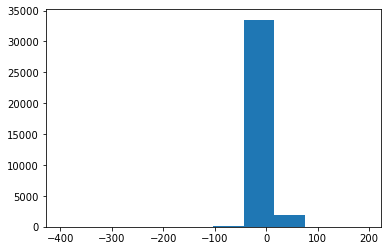

In [21]:
#Any missing pixel
missing_pred = modis_net(torch.Tensor(missing_train)).detach().numpy()
plt.hist(missing_pred)

(array([15554.,  9118.,  1004.,   577.,    15.,    15.,    15.,    42.,
           27.,    18.]),
 array([-0.6000755,  5.676941 , 11.953958 , 18.230974 , 24.50799  ,
        30.785007 , 37.062023 , 43.33904  , 49.61606  , 55.893074 ,
        62.17009  ], dtype=float32),
 <BarContainer object of 10 artists>)

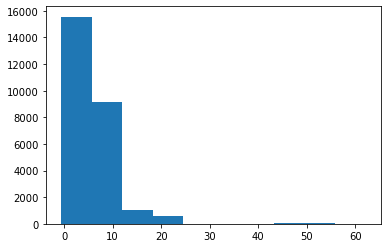

In [22]:
#Only 250
missing_train = x_train[np.all(x_train*255 == 250., axis = (1,2,3))]

missing_pred = modis_net(torch.Tensor(missing_train)).detach().numpy()
plt.hist(missing_pred)

In [23]:
#dropout off, all missing values
#[201, 250, 255] 
modis_net.train(False)
print(np.unique(modis_net(torch.Tensor(missing_train)).detach().numpy()))

print(np.mean(y_train.iloc[np.all(x_train*255 == 250., axis = (1,2,3))].snowpack))


[11.423086 11.423087]
11.975865453856382


## Plot of missingness vs predictions, training vs testing

In [28]:
#How much missingness?
x_train_missness = np.sum(x_train*255 > 100.1, axis = (1,2,3))
x_test_missness = np.sum(x_test*255 > 100.1, axis = (1,2,3))

In [40]:
modis_net.eval()

yhat_test = modis_net(torch.Tensor(x_test)).detach().numpy().squeeze()
yhat_train = modis_net(torch.Tensor(x_train)).detach().numpy().squeeze()

testing rmse: 9.009451532005382
training rmse: 10.031726136971413


In [136]:
np.save("C:/Users/Matt/Dropbox/SnowComp/FinalData/yhat_test.npy", yhat_test)
np.save("C:/Users/Matt/Dropbox/SnowComp/FinalData/yhat_train.npy", yhat_train)

yhat_test = np.load("C:/Users/Matt/Dropbox/SnowComp/FinalData/yhat_test.npy")
yhat_train = np.load("C:/Users/Matt/Dropbox/SnowComp/FinalData/yhat_train.npy")

In [137]:
train_error = np.abs(yhat_train - y_train.snowpack.values)
test_error = np.abs(yhat_test - y_test.snowpack.values)

print("testing rmse:", np.sqrt(((y_test.snowpack.values - yhat_test)**2).mean()))
print("training rmse:", np.sqrt(((y_train.snowpack.values - yhat_train)**2).mean()))

testing rmse: 9.009451532005382
training rmse: 10.031726136971413


Text(0, 0.5, 'Absolute Value of Error')

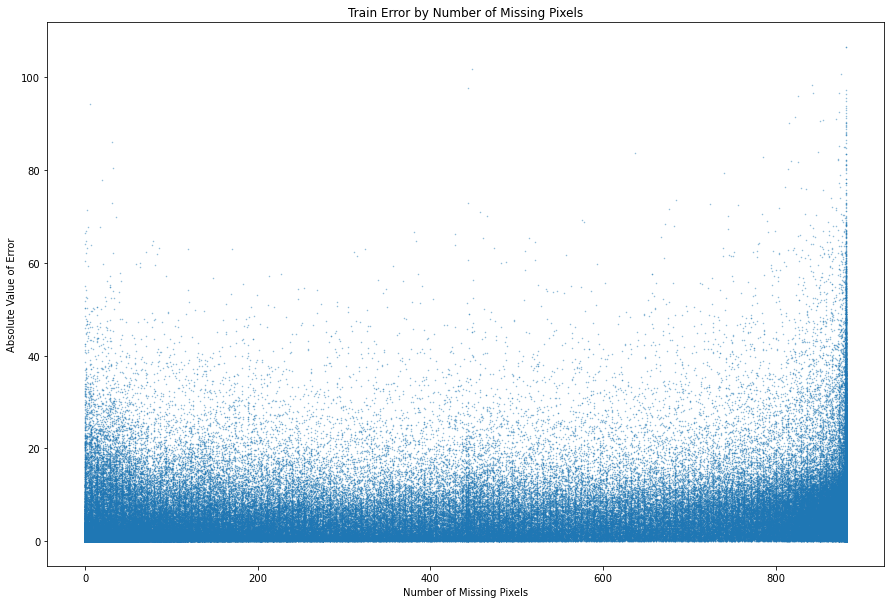

In [41]:
x_name = 'Number of Missing Pixels'
y_name = 'Absolute Value of Error'

plt.figure(figsize=(15, 10))

plt.scatter(x_train_missness, train_error, 
            marker = '.', s = 1, alpha = .5)
plt.title('Train Error by Number of Missing Pixels')
plt.xlabel(x_name)
plt.ylabel(y_name)
# plt.legend();


Text(0, 0.5, 'Absolute Value of Error')

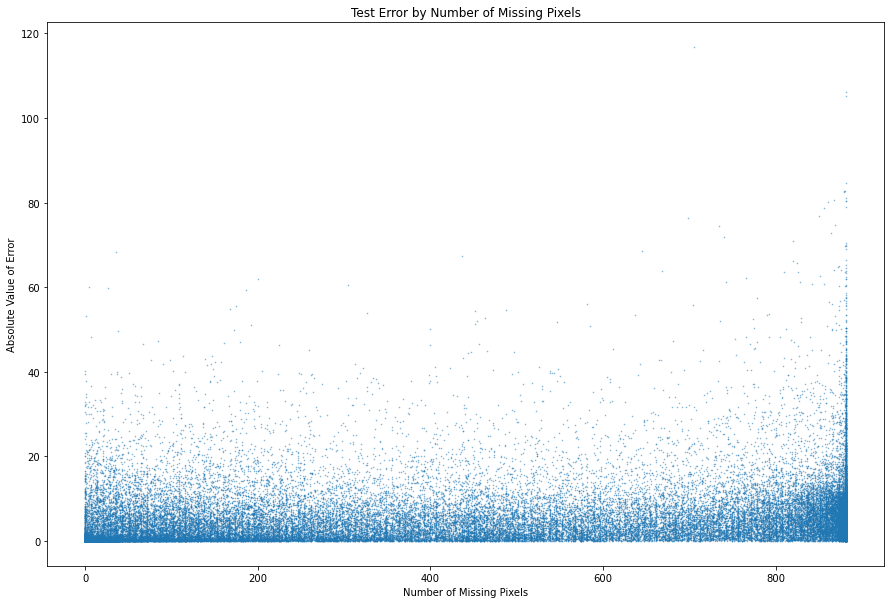

In [128]:
x_name = 'Number of Missing Pixels'
y_name = 'Absolute Value of Error'

plt.figure(figsize=(15, 10))

plt.scatter(x_test_missness, test_error, 
            marker = '.', s = 1.4, alpha = .5)
plt.title('Test Error by Number of Missing Pixels')
plt.xlabel(x_name)
plt.ylabel(y_name)
# plt.legend();

In [61]:
#courtesy of https://james-brennan.github.io/posts/lowess_conf/
def lowess(x, y, f=1./10.):
    """
    Basic LOWESS smoother with uncertainty. 
    Note:
        - Not robust (so no iteration) and
             only normally distributed errors. 
        - No higher order polynomials d=1 
            so linear smoother.
    """
    # get some paras
    xwidth = f*(x.max()-x.min()) # effective width after reduction factor
    N = len(x) # number of obs
    # Don't assume the data is sorted
    order = np.argsort(x)
    # storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # define the weigthing function -- clipping too!
    tricube = lambda d : np.clip((1- np.abs(d)**3)**3, 0, 1)
    # run the regression for each observation i
    for i in trange(N):
        dist = np.abs((x[order][i]-x[order]))/xwidth
        w = tricube(dist)
        # form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # solve the syste
        sol = np.linalg.solve(ATA, ATb)
        # predict for the observation only
        yest = A[i].dot(sol)# equiv of A.dot(yest) just for k
        place = order[i]
        y_sm[place]=yest 
        sigma2 = (np.sum((A.dot(sol) -y [order])**2)/N )
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * 
                                A[i].dot(np.linalg.inv(ATA)
                                                    ).dot(A[i]))
    return y_sm, y_stderr




  0%|          | 0/221733 [00:00<?, ?it/s]

In [ ]:
a = np.arange(0, x_train_missness.shape[0])
# idx = np.random.choice(a, x_train_missness.shape[0], replace=False) #10000 samples
idx = np.random.choice(a, 60_000, replace=False) #10000 samples

x = x_train_missness[idx]


order = np.argsort(x)

#run it
y_sm, y_std = lowess(x, train_error, f=1./4.)


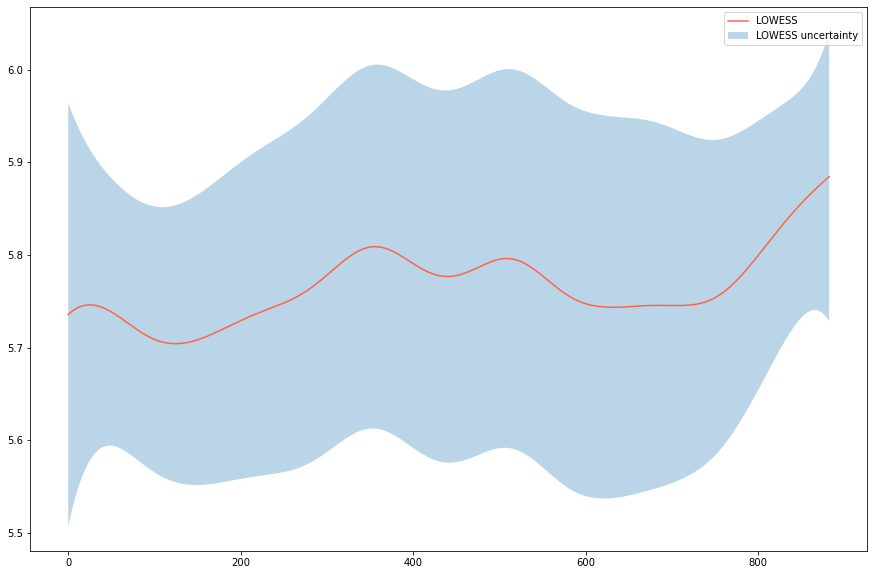

In [133]:
plt.figure(figsize=(15, 10))

plt.plot(x[order], y_sm[order], color='tomato', label='LOWESS')

plt.fill_between(x[order], y_sm[order] - 1.96*y_std[order],
                 y_sm[order] + 1.96*y_std[order], alpha=0.3, label='LOWESS uncertainty')




# plt.plot(x, train_error[idx], 'k.', label='Observations', markersize = 1.2, alpha= .5)

plt.legend(loc='best')


In [ ]:
a = np.arange(0, x_test_missness.shape[0])
idx = np.random.choice(a, x_test_missness.shape[0], replace=False) #10000 samples

x = x_test_missness[idx]


order = np.argsort(x)

#run it
y_sm, y_std = lowess(x, test_error, f=1./4.)

  0%|          | 0/52400 [00:00<?, ?it/s]

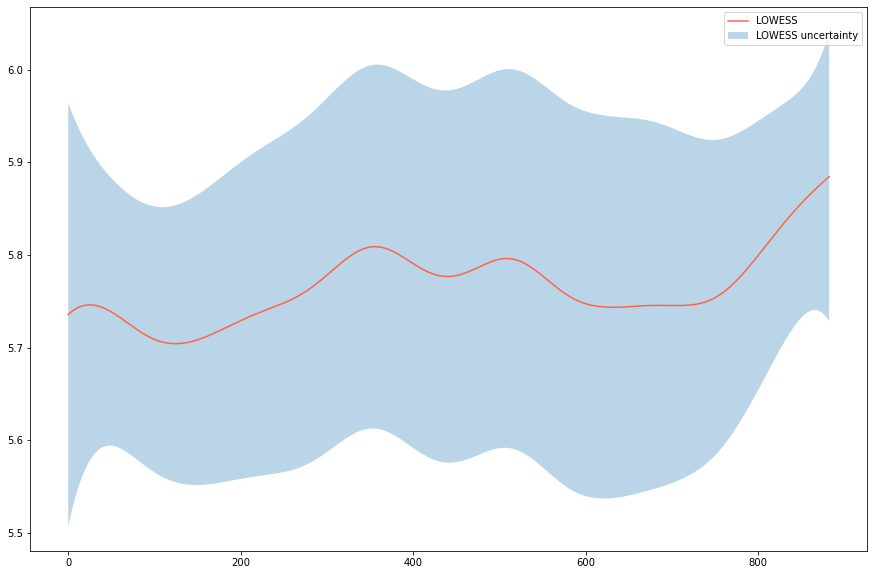

In [132]:
plt.figure(figsize=(15, 10))

plt.plot(x[order], y_sm[order], color='tomato', label='LOWESS')

plt.fill_between(x[order], y_sm[order] - 1.96*y_std[order],
                 y_sm[order] + 1.96*y_std[order], alpha=0.3, label='LOWESS uncertainty')




# plt.plot(x, test_error[idx], 'k.', label='Observations', markersize = 1.2, alpha= .5)

plt.legend(loc='best')


## Percentile plot of errors

Missing at ever pixel value, with min of 95 observations for 675, max of 35,602 for pix value 882

In [100]:
train_err_df = pd.DataFrame(data = {'n_missing':x_train_missness, 'error':train_error})
train_err_df = train_err_df.groupby('n_missing')

train_quants = train_err_df.quantile([.05, .25, .5, .75, .95, .99]).reset_index()
train_quants.rename(columns = {'level_1':'Quantile'}, inplace = True)

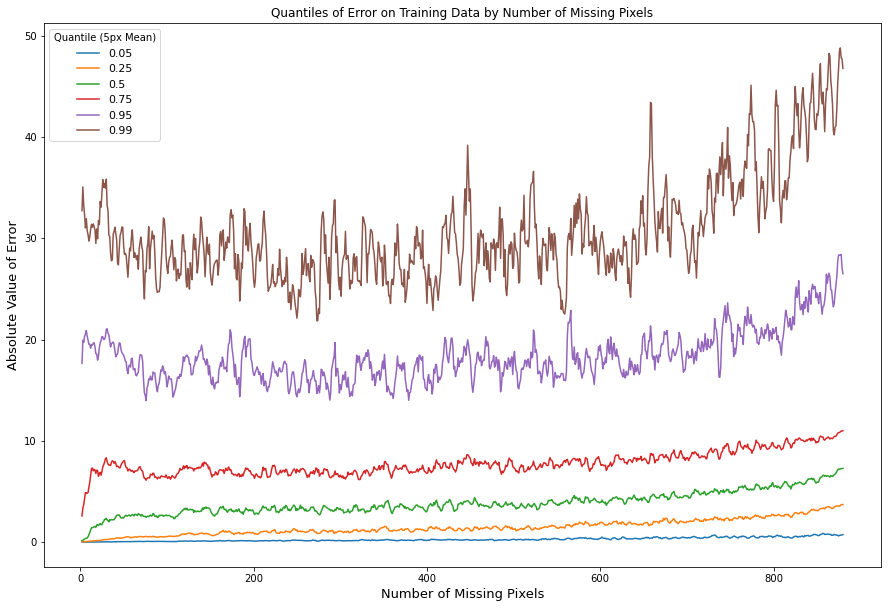

In [121]:
fig, ax = plt.subplots(figsize = (15, 10))

for key, grp in train_quants.groupby(['Quantile']):
    grp = grp.rolling(5).mean()
    ax = grp.plot(ax=ax, kind='line', x='n_missing', y='error', label=key)

plt.legend(loc='best', title = 'Quantile (5px Mean)', fontsize = 11)
x_name = 'Number of Missing Pixels'
y_name = 'Absolute Value of Error'
plt.xlabel(x_name, fontsize = 13)
plt.ylabel(y_name, fontsize = 13)

plt.title("Quantiles of Error on Training Data by Number of Missing Pixels" )

plt.show()


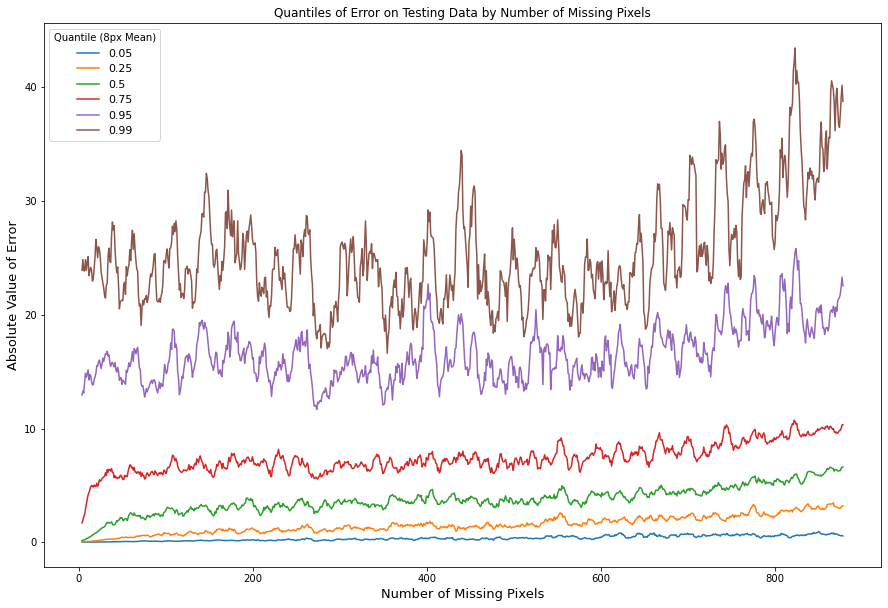

In [126]:
test_err_df = pd.DataFrame(data = {'n_missing':x_test_missness, 'error':test_error})
test_err_df = test_err_df.groupby('n_missing')

test_quants = test_err_df.quantile([.05, .25, .5, .75, .95, .99]).reset_index()
test_quants.rename(columns = {'level_1':'Quantile'}, inplace = True)

fig, ax = plt.subplots(figsize = (15, 10))

for key, grp in test_quants.groupby(['Quantile']):
    grp = grp.rolling(8).mean()
    ax = grp.plot(ax=ax, kind='line', x='n_missing', y='error', label=key)

plt.legend(loc='best', title = 'Quantile (8px Mean)', fontsize = 11)
x_name = 'Number of Missing Pixels'
y_name = 'Absolute Value of Error'
plt.xlabel(x_name, fontsize = 13)
plt.ylabel(y_name, fontsize = 13)

plt.title("Quantiles of Error on Testing Data by Number of Missing Pixels" )

plt.show()

## Plot of missingness vs dropout errors, training vs testing

 - Percent of intervals capturing the truth, with error bars
 - What percentile is the observation in those values (i.e. is it mean 0?)
 - Replicate the above percentile graph of dropout errors?

In [129]:
dout_pred_train = np.load("C:/Users/Matt/Dropbox/SnowComp/FinalData/DropoutPredsTrain.npy")
dout_pred_test = np.load("C:/Users/Matt/Dropbox/SnowComp/FinalData/DropoutPredsTest.npy")

In [150]:
#Percent of true value falling in the range of dropout value
in_dprange_train = ((dout_pred_train.max(axis=1) >= y_train.snowpack.values) &
                    (y_train.snowpack.values >= dout_pred_train.min(axis=1)))
 
in_dprange_test = ((dout_pred_test.max(axis=1) >= y_test.snowpack.values) &
                    (y_test.snowpack.values >= dout_pred_test.min(axis=1)))

train_err_df = train_err_df.obj
test_err_df = test_err_df.obj

train_err_df['in_dprange'] = in_dprange_train
test_err_df['in_dprange'] = in_dprange_test

In [193]:
perc_inrange_train = train_err_df.groupby('n_missing').sum().in_dprange/train_err_df.groupby('n_missing').size()
perc_inrange_train = perc_inrange_train.to_frame('percent')
perc_inrange_train['n'] = train_err_df.groupby('n_missing').size()
perc_inrange_train['dy'] = np.sqrt(perc_inrange_train.percent *(1-perc_inrange_train.percent)/ perc_inrange_train.n)*1.95

perc_inrange_test = test_err_df.groupby('n_missing').sum().in_dprange/test_err_df.groupby('n_missing').size()
perc_inrange_test = perc_inrange_test.to_frame('percent')
perc_inrange_test['n'] = test_err_df.groupby('n_missing').size()
perc_inrange_test['dy'] = np.sqrt(perc_inrange_test.percent *(1-perc_inrange_test.percent)/ perc_inrange_test.n)*1.95

Text(0.5, 1.0, 'Percentage of Ranges of Dropout Draws Containing True Values (Training Set)')

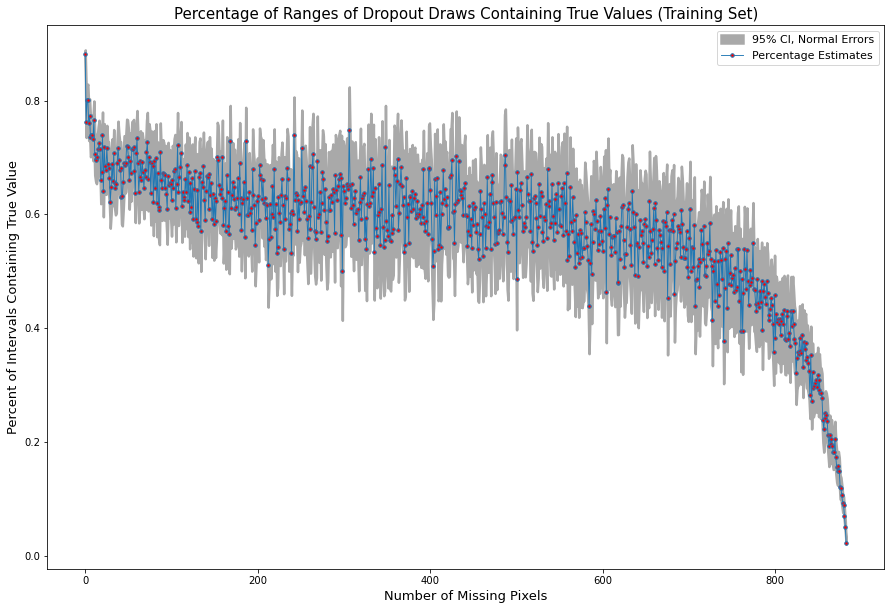

In [256]:
fig, ax = plt.subplots(figsize = (15, 10))
# plt.errorbar(perc_inrange_train.index,perc_inrange_train['percent'],
#              yerr=perc_inrange_train['dy'], capsize = 2, markersize = 3,
#               ecolor = 'grey')

ax.fill_between(perc_inrange_train.index,
                perc_inrange_train['percent'] -perc_inrange_train['dy'] ,
                perc_inrange_train['percent'] +perc_inrange_train['dy'],
                color = 'darkgrey',
                label = "95% CI, Normal Errors",
                linewidth= 2.5)
ax.plot(perc_inrange_train.index, perc_inrange_train['percent'], label = "Percentage Estimates",
       marker = 'o', linewidth = .9, markersize = 3.5, markerfacecolor ='red')

plt.legend(loc='best', title = '', fontsize = 11)
x_name = 'Number of Missing Pixels'
y_name = 'Percent of Intervals Containing True Value'
plt.xlabel(x_name, fontsize = 13)
plt.ylabel(y_name, fontsize = 13)
plt.title('Percentage of Ranges of Dropout Draws Containing True Values (Training Set)', fontsize = 15)


Text(0.5, 1.0, 'Percentage of Ranges of Dropout Draws Containing True Values (Testing Set)')

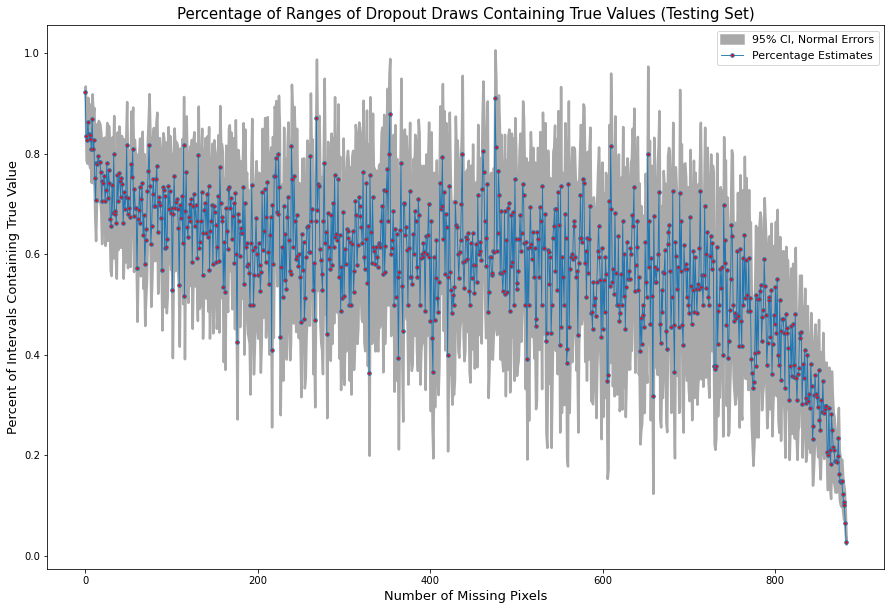

In [257]:
fig, ax = plt.subplots(figsize = (15, 10))
# plt.errorbar(perc_inrange_test.index,perc_inrange_test['percent'],
#              yerr=perc_inrange_test['dy'], capsize = 2, markersize = 3,
#               ecolor = 'grey')

ax.fill_between(perc_inrange_test.index,
                perc_inrange_test['percent'] -perc_inrange_test['dy'] ,
                perc_inrange_test['percent'] +perc_inrange_test['dy'],
                color = 'darkgrey',
                label = "95% CI, Normal Errors",
                linewidth= 2.5)
ax.plot(perc_inrange_test.index, perc_inrange_test['percent'], label = "Percentage Estimates",
       marker = 'o', linewidth = .9, markersize = 3.5, markerfacecolor ='red')

plt.legend(loc='best', title = '', fontsize = 11)
x_name = 'Number of Missing Pixels'
y_name = 'Percent of Intervals Containing True Value'
plt.xlabel(x_name, fontsize = 13)
plt.ylabel(y_name, fontsize = 13)
plt.title('Percentage of Ranges of Dropout Draws Containing True Values (Testing Set)', fontsize = 15)

## Average width of Dropout Bands

(array([186776.,  30165.,   4265.,    463.,     56.,      5.,      1.,
             0.,      0.,      2.]),
 array([  0.05301666,  16.1057611 ,  32.15850554,  48.21124997,
         64.26399441,  80.31673884,  96.36948328, 112.42222772,
        128.47497215, 144.52771659, 160.58046103]),
 <BarContainer object of 10 artists>)

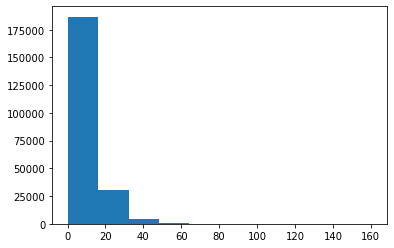

In [262]:
#plot ranges along missing values

plt.hist(np.ptp(dout_pred_train, axis =1 ))


## Value prediction

If there are middle (or more) clouds, do we predict more snow? Calculate as relative to mean value for location.